In [1]:
from google.colab import drive
drive.mount('/content/drive')
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LambdaCallback
from keras import backend as K
from keras import activations
import keras
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import Callback
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from scipy.stats import norm

Mounted at /content/drive


In [2]:
# Load arrays from Google Drive
X_train = np.load('/content/drive/My Drive/X_train_new.npy')
y_train = np.load('/content/drive/My Drive/y_train_new.npy')
X_test = np.load('/content/drive/My Drive/X_test_new.npy')
y_test = np.load('/content/drive/My Drive/y_test_new.npy')

In [3]:
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_shape=(784,)))
model.add(Dense(128, activation='sigmoid', input_shape=(128,)))
model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
ratio = 1
ds_size = len(X_train)  * ratio
batchsize_train = 128
dense_size = 128
n_batches = int(ds_size // batchsize_train)
n_epochs = 3
n_layers = 2

In [5]:
shapes = (n_batches, batchsize_train, dense_size)
layer_activations = []
for _ in range(n_layers):
  epochs = []
  for i in range(n_epochs):
    epochs.append(np.empty(shapes))
  layer_activations.append(epochs)
model_output = []
weights = []

class CustomCallback(Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        for i in range(n_layers):
          model_output.append(model.layers[i].output)
        self.ok = False #used for testing

    def on_epoch_begin(self, epoch, logs=None):
      self.neuron_activations = []
      for i in range(n_layers):
        self.neuron_activations.append(layer_activations[i][epoch])
      if epoch == 0: ## replace 0 with the epoch you wanna test
        self.ok = True

    def on_batch_begin(self, batch, logs=None):
        get_activations = K.function([model.layers[0].input], model_output)
        if batch != (n_batches):  # we ignore the last, uncompleted batch so we can have a matrix
          get_act = get_activations([X_train[(batch) * batchsize_train: (batch + 1) * batchsize_train]])
          for i in range(n_layers):
            activations = get_act[i]
            self.neuron_activations[i][batch]= np.array(activations)

custom_callback = CustomCallback()

model.fit(X_train, y_train, epochs=n_epochs, batch_size=batchsize_train, callbacks=[custom_callback])


Epoch 1/3
  6/516 [..............................] - ETA: 42s - loss: 2.5006 - accuracy: 0.1393

516/516 [==============================] - 16s 23ms/step - loss: 0.6482 - accuracy: 0.8412
Epoch 2/3
516/516 [==============================] - 9s 18ms/step - loss: 0.2213 - accuracy: 0.9360
Epoch 3/3
516/516 [==============================] - 9s 18ms/step - loss: 0.1659 - accuracy: 0.9520


Properly arrange list

In [6]:
neuron_activations = []
for j in range(n_layers):
  for i in range(n_epochs):
    layer_activations[j][i] = np.reshape(layer_activations[j][i], (n_batches * batchsize_train, dense_size ))
    layer_activations[j][i] = layer_activations[j][i].T.reshape((dense_size,-1))
  neuron_activations.append(np.hstack(layer_activations[j]))


Plot distribuition

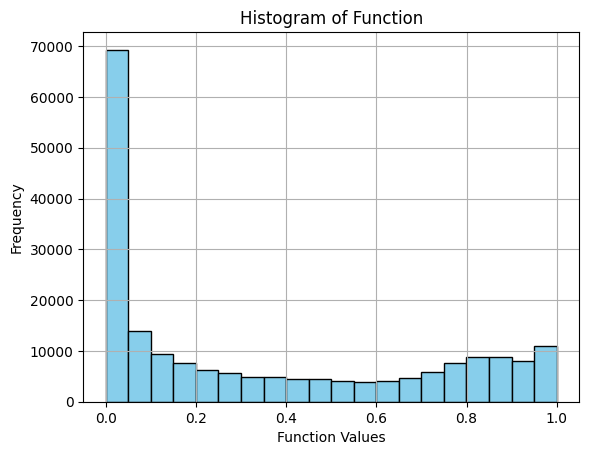

In [7]:
plt.hist(neuron_activations[0][18], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Function')
plt.xlabel('Function Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Sort based on class


In [8]:
activations_class = []
for layer_ in range(n_layers):
  layer = []
  for neuron_ in range(dense_size):
    neuron_class = []
    for class_ in range(11):
      neuron_class.append([])
    for image_ in range(int(n_epochs * n_batches * batchsize_train)):
      label = np.argmax(y_train[image_ % (n_batches * batchsize_train)])
      neuron_class[label].append(neuron_activations[layer_][neuron_][image_])
    layer.append(neuron_class)
  activations_class.append(layer)

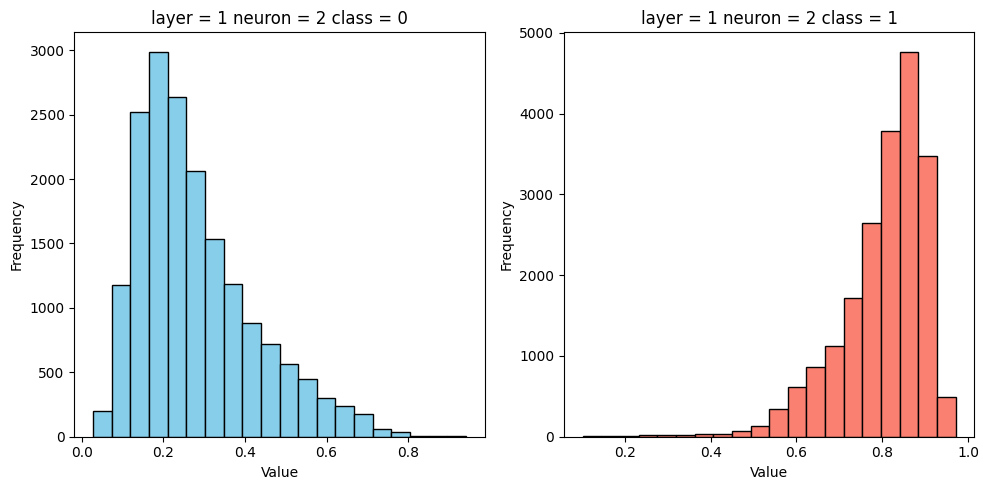

In [9]:
(curr_layer, curr_neuron, curr_class) = 1, 2, 0
(curr_layer2, curr_neuron2, curr_class2) = 1, 2, 1

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(activations_class[curr_layer][curr_neuron][curr_class], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title(f'layer = {curr_layer} neuron = {curr_neuron} class = {curr_class}')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(activations_class[curr_layer2][curr_neuron2][curr_class2], bins=20, color='salmon', edgecolor='black')
axs[1].set_title(f'layer = {curr_layer2} neuron = {curr_neuron2} class = {curr_class2}')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

We now compute the ranges of the neurons

In [10]:
range_classes = np.empty((n_layers,dense_size,11,2))
for layer in range(n_layers):
  for i in range(dense_size):
    for class_ in range(11):
      range_classes[layer][i][class_][0] = np.min(activations_class[layer][i][class_])
      range_classes[layer][i][class_][1] = np.max(activations_class[layer][i][class_])

Create random list to get out of range

In [11]:
random_X_test = np.random.choice([-1., 1.], size=(11000, 784), p=[0.5, 0.5])
random_X_test += np.random.rand(11000, 784)  # Add random values between 0 and 1

Get activations from tests and random tests

In [12]:
get_testing_a = K.function([model.layers[0].input],
                                  model_output)
get_label_pred = K.function([model.layers[0].input],
                                  [model.layers[-1].output])
layers_output_random = get_testing_a([random_X_test])
label_pred_random = get_label_pred([random_X_test])[0]

In [13]:

max_indices = np.argmax(label_pred_random, axis=1) # having the right label eg 7 or 4
y_test_predict_random = np.zeros((max_indices.size, 11))
y_test_predict_random[np.arange(max_indices.size), max_indices] = 1 # one hot encoded

Find correlation

In [15]:
def find_corr(array_v, array_bool):
  numeric_boolean_values = array_bool.astype(int)
  pearson_corr, pearson_p_value = pearsonr(array_v, numeric_boolean_values)
  spearman_corr, spearman_p_value = spearmanr(array_v, numeric_boolean_values)
  return pearson_corr, pearson_p_value, spearman_corr, spearman_p_value

Rearrange the list properly

In [16]:
layers_output_random = np.array(layers_output_random)
layers_output_random = layers_output_random.transpose(0, 2, 1)

In [17]:
n_images_random = len(random_X_test)
percentages_random = np.empty((n_images_random, 11))
for i in range(n_images_random):
  for class_ in range(11):
    count = 0
    for layer in range(n_layers):
      for neuron in range(dense_size):
        if range_classes[layer][neuron][class_][0] <= layers_output_random[layer][neuron][i] <= range_classes[layer][neuron][class_][1]:
          count +=1
    percentages_random[i][class_] = count / (n_layers * dense_size) * 100

In [18]:
percentages_random[1000]

array([74.609375, 66.796875, 80.078125, 82.03125 , 67.96875 , 82.03125 ,
       66.40625 , 73.828125, 76.171875, 71.484375, 66.015625])

Find Correlation and Accuracy for NonImage input

In [19]:
difference_list_rand = np.zeros(len(percentages_random), dtype=bool)
percentage_prediction_rand = np.zeros(len(percentages_random),dtype=bool)
interesting_rand = []
for percent_list_ in range(len(percentages_random)):
  percent_list = percentages_random[percent_list_]
  label_predict = np.argmax(percent_list)
  percentage_prediction_rand[percent_list_] = (np.argmax(y_test_predict_random[percent_list_]) == 10)
  check_difference = False
  for percent in percent_list:
    if abs(percent - percent_list[label_predict]) <= 10. and percent != percent_list[label_predict]:
      check_difference = True
      difference_list_rand[percent_list_] = True
      break
  if not check_difference :
    interesting_rand.append(percent_list)

In [20]:
n_wins_diff_rand = 0
for i in range(len(difference_list_rand)):
  if difference_list_rand[i] and percentage_prediction_rand[i]:
    n_wins_diff_rand += 1

In [21]:
n_diff_rand = np.sum(difference_list_rand)
n_wins_rand = np.sum(percentage_prediction_rand)
print(f'Accuracy when there is a < 10% difference: {n_wins_diff_rand/n_diff_rand}')
print(f'Accuracy when there is a >= 10% difference: {(n_wins_rand - n_wins_diff_rand)/(len(percentage_prediction_rand) - n_diff_rand)}')

Accuracy when there is a < 10% difference: 0.981959819598196
Accuracy when there is a >= 10% difference: 1.0


In [22]:
find_corr(difference_list_rand, percentage_prediction_rand)

(-0.10060392436974158,
 3.806679370969016e-26,
 -0.10060392436974194,
 3.8066793709682433e-26)

In [23]:
k = 0
for percs_ in range(len(percentages_random)):
  percs = percentages_random[percs_]
  label_predict = np.argmax(percent_list)
  if np.argmax(y_test_predict_random[percs_]) != label_predict:
    k+= 1
print(k)

88


We now compute Correlation and Accuracy for The Image input

In [25]:
layers_output = get_testing_a([X_test])
label_pred = get_label_pred([X_test])[0]

In [26]:
max_indices = np.argmax(label_pred, axis=1) # having the right label eg 7 or 4
y_test_predict = np.zeros((max_indices.size, 11))
y_test_predict[np.arange(max_indices.size), max_indices] = 1 # one hot encoded

In [27]:
layers_output= np.array(layers_output)
layers_output = layers_output.transpose(0, 2, 1)

In [28]:
n_images = len(y_test)
percentages = np.empty((n_images, 11))
for i in range(n_images):
  for class_ in range(11):
    count = 0
    for layer in range(n_layers):
      for neuron in range(dense_size):
        if range_classes[layer][neuron][class_][0] <= layers_output[layer][neuron][i] <= range_classes[layer][neuron][class_][1]:
          count +=1
    percentages[i][class_] = count / (n_layers * dense_size) * 100

Compute Correlation and Acuracy for Image input

In [30]:
difference_list = np.zeros(len(percentages), dtype=bool)
percentage_prediction = np.zeros(len(percentages),dtype=bool)
interesting_all = []
for percent_list_ in range(len(percentages)):
  percent_list = percentages[percent_list_]
  label_predict = np.argmax(percent_list)
  percentage_prediction[percent_list_] = (np.argmax(y_test_predict[percent_list_]) == np.argmax(y_test[percent_list_]))
  check_difference = False
  for percent in percent_list:
    if abs(percent - percent_list[label_predict]) <= 10. and percent != percent_list[label_predict]:
      check_difference = True
      difference_list[percent_list_] = True
      break
  if not check_difference :
    interesting_all.append(percent_list)

In [31]:
n_wins_diff = 0
for i in range(len(difference_list)):
  if difference_list[i] and percentage_prediction[i]:
    n_wins_diff += 1

In [32]:
n_diff = np.sum(difference_list)
n_wins = np.sum(percentage_prediction)
print(f'Accuracy when there is a < 10% difference: {n_wins_diff/n_diff}')
print(f'Accuracy when there is a >= 10% difference: {(n_wins - n_wins_diff)/(len(percentage_prediction) - n_diff)}')

Accuracy when there is a < 10% difference: 0.9510657460222155
Accuracy when there is a >= 10% difference: 1.0


In [33]:
find_corr(difference_list, percentage_prediction)

(-0.06846982267000325,
 6.536486714606556e-13,
 -0.06846982267000333,
 6.53648671460626e-13)